In [40]:
import sys, os
sys.path.append("..")

In [41]:
import pfb
import numpy as np
from constants import SINC,LBLOCK,NTAP
from numpy.fft import fft,rfft,ifft,irfft
import matplotlib.pyplot as plt

In [42]:
fft(np.ones(10)) / np.sqrt(10)

array([3.16227766+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j,
       0.        +0.j, 0.        +0.j])

In [52]:
def A(x):
    b = pfb.forward_pfb(x)
    b = irfft(b)
    b = np.concatenate([b , b[:3,:]],axis=0)
    return b.flatten()

def A_inv(b_flat,lblock=LBLOCK):
    if len(b_flat)/lblock != len(b_flat)//lblock: raise Exception("the dimensions of the input does not match lblock:\n\
        {} should be an integer".format(len(b_flat)/lblock))
    b = np.array([b_flat[i*lblock:(i+1)*lblock] for i in range(k-3)]) # -3 drops the last three rows
    b = rfft(b) 
    return pfb.inverse_pfb(b) 

def A_quantize(x,delta=0.1): # delta is the quantization interval 
    b = pfb.forward_pfb(x) 
    b = pfb.quantize( b , np.sqrt(2*(b.shape[1] - 1)) * delta ) # quantize the pfb 
    b = irfft(b) # same as apply along axis=1
    b = np.concatenate([b , b[:3,:]],axis=0) 
    return b.flatten()

def R(x,lblock=LBLOCK):
    lx = len(x)
    if lx/lblock != lx//lblock: 
        raise Exception("len x={} is not divisible by lblock={}".format(lx,lblock))
    k = lx // lblock
    out = np.zeros(lx)
    for i in range(k):
        out[lblock*i:lblock*(i+1)] = x[lblock*(k-i-1):lblock*(k-i)]
    return out

def AT(x): # the transpose of A
    return R(A(R(x)))


In [101]:
arr = np.arange(50)
arr[1::2]

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49])

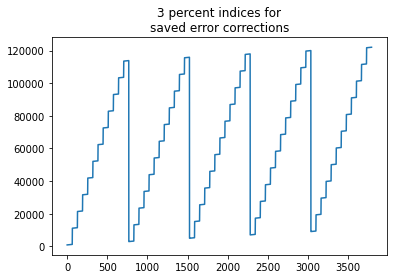

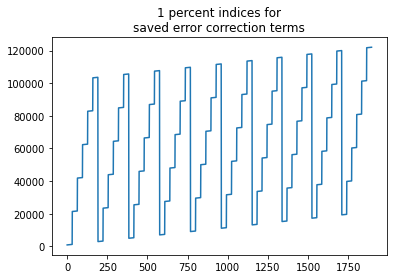

In [102]:
width_3 = 316 
n_per_step = 5 # one out of five of the data points in the range are saved

saved_data_3perc = np.arange(2048//2 - width//2, 2048//2 + width//2) 

# now make the fifths spread out between datapts
first_fifth = saved_data_3perc[0::5]
second_fifth = saved_data_3perc[1::5]
third_fifth = saved_data_3perc[2::5]
fourth_fifth = saved_data_3perc[3::5]
fifth_fifth = saved_data_3perc[4::5]

saved_idxs_3 = np.concatenate([
    np.concatenate([first_fifth + i*5*LBLOCK for i in range((k+4)//5)]),
    np.concatenate([second_fifth + LBLOCK + i*5*LBLOCK for i in range((k+4-1)//5)]),
    np.concatenate([third_fifth + 2*LBLOCK + i*5*LBLOCK for i in range((k+4-2)//5)]),
    np.concatenate([fourth_fifth + 3*LBLOCK + i*5*LBLOCK for i in range((k+4-3)//5)]),
    np.concatenate([fifth_fifth + 4*LBLOCK + i*5*LBLOCK for i in range((k+4-4)//5)])
])
plt.plot(saved_idxs_3)
plt.title("3 percent indices for\nsaved error corrections")
plt.show()

# same as above but for 1%
width_1 = 208
n_per_step = 10 # one out of ten of the data points in the range are saved
# corresponds to height of 51 pixels

# LBLOCK === 2048
saved_data_1perc = np.arange(LBLOCK//2 - width//2 , LBLOCK//2 + width//2)
tenths = [saved_data_1perc[i::n_per_step] for i in range(n_per_step)]
saved_idxs_1 = np.concatenate([
    np.concatenate(
        [tenths[s] + s*LBLOCK + i*n_per_step*LBLOCK for i in range((k+n_per_step-s-1)//n_per_step)]
    ) for s in range(n_per_step)
])
plt.plot(saved_idxs_1)
plt.title("1 percent indices for\nsaved error correction terms")
plt.show()

In [128]:
def conjugate_gradient_descent(B,u,x0=None,rmin=0.1,max_iter=100): 
    # u is the data, B is the symmetric matrix operator (written as func)
    # solve for x : Bx = u
    if type(x0) != np.ndarray: x0 = np.zeros(len(u)) # if x0 is None basically
    x = x0.copy()
    print("Input")
    print("\n\nx0={}".format(x)) 
    print("\n\nu={}".format(u))
    r = u - B(x0)
    if np.sqrt(np.dot(r,r)) < rmin:
        print("Initial value already close enough to target value, no need for gradient descent.")
        return x
    p = r.copy()
    for i in range(max_iter): 
        Bp = B(p)
        alpha = np.dot(r,r) / np.dot(p,Bp)
        x = x + alpha * p
        r_new = r - alpha * Bp
        print("({}) |r| = {}".format(i,np.sqrt(np.dot(r,r))))
        if np.sqrt(np.dot(r,r)) < rmin:
            print("terminating after {} iterations,\n\
                remainder smaller than minimum value {}".format(i,rmin))
            break
        beta = np.dot(r_new,r_new) / np.dot(r,r)
        p = r_new + beta * p
        r = r_new
    print("conjugate gradient computed") 
    print("\n\nx_out={}".format(x)) 
    return x

In [167]:
def simulate_quantization_error(delta=0.05 , n_sims = 100):
    # input param delta is the quantization step
    x_arr = [] # list of input timestream arrays
    x0_arr = [] # list of IPFB output arrays
    x1_perc_arr = [] # list of reconstructed arrays with 1% extra data
    x3_perc_arr = [] # list of reconstructed arrays with 3% extra data
    for sim in range(n_sims):
        k = 60
        x = np.random.normal(0,1,LBLOCK*k) 

        d = A_quantize(x,delta)
        # N_inv and Q_inv are diagonal matrices so we store them as 1D-arrays
        N_inv = np.ones(len(x)) * 6 / delta**2

        ### 3 percent of original data given as prior
        # the noise matrix for the prior
        prior_3 = np.zeros(len(x)) # what we know about x, information we saved
        prior_3[saved_idxs_3] = pfb.quantize_real(x[saved_idxs_3] , delta) # quantized original signal

        Q_inv_3 = np.zeros(len(x)) # infinite uncertainty cause we don't know them
        Q_inv_3[saved_idxs_3] = np.ones(len(saved_idxs_3)) * 12 / delta**2 # 8 bits per real number (finer std because no complex)

        B_3 = lambda ts: AT(N_inv * A(ts)) + Q_inv_3 * ts # think ts===x
        u_3 = AT(N_inv * d) + Q_inv_3 * prior_3 # this is same as mult prior by var=12/delta^2

        ### 1 percent of original data given as prior
        # the noise matrix for the prior
        prior_1 = np.zeros(len(x)) # what we know about x, information we saved
        prior_1[saved_idxs_1] = pfb.quantize_real(x[saved_idxs_1] , delta) # quantized original signal

        Q_inv_1 = np.zeros(len(x)) 
        Q_inv_1[saved_idxs_1] = np.ones(len(saved_idxs_1)) * 12 / delta**2 # 8 bits per real number

        B_1 = lambda ts: AT(N_inv * A(ts)) + Q_inv_1 * ts # think ts===x
        u_1 = AT(N_inv * d) + Q_inv_1 * prior_1

        ### Optimize CHI squared using conjugate gradient method
        # x0 is the standard IPFB reconstruction
        x0 = np.real( A_inv(d) )
        # indices to set to zero when initializing reconstruction (because errors blow up at these indices)
        zero_idxs = np.concatenate([np.arange(LBLOCK // 2 - 200+1 + i*LBLOCK , LBLOCK // 2 + 200+1 + i*LBLOCK) for i in range(k)])
        x0_with_zeros = x0.copy()
        x0_with_zeros[zero_idxs] = np.zeros(len(zero_idxs))
        # print("\n\nd={}".format(d)) # trace, they are indeed real
        # print("\n\nx_0={}".format(x0)) # complex dtype but zero imag componant

        print("\nConjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)")
        x_out_3 = conjugate_gradient_descent(B_3,u_3,x0=x0_with_zeros,rmin=1000,max_iter=30)
        print("\n\n-----------------------------------------------------------------------------------------------")
        print("-----------------------------------------------------------------------------------------------")
        print("\n\n\nConjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)")
        x_out_1 = conjugate_gradient_descent(B_1,u_1,x0=x0_with_zeros,rmin=2000,max_iter=35)
        
        # save the arrays
        x_arr.append(x)
        x0_arr.append(x0) 
        x1_perc_arr.append(x_out_1)
        x3_perc_arr.append(x_out_3)
    return np.array(x_arr), np.array(x0_arr), np.array(x1_perc_arr), np.array(x3_perc_arr)

In [175]:
delta = 0.1
x_arr, x0_arr, x1_perc_arr, x3_perc_arr = simulate_quantization_error(delta , n_sims=250)

# estimate the RMS errors
rmse_ipfb = np.sqrt( np.mean((x0_arr - x_arr)**2, axis=0) )
rmse_1_perc = np.sqrt( np.mean((x1_perc_arr - x_arr)**2, axis=0) )
rmse_3_perc = np.sqrt( np.mean((x3_perc_arr - x_arr)**2, axis=0) )


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 1.32815303 -0.14172318 -2.15732127 ... -0.0883913  -1.57914452
 -0.14150625]


u=[-384.53037683 -683.78085239   96.18833745 ...  -53.02582222 -947.42651928
  -84.89937153]
(0) |r| = 114688.60602781728
(1) |r| = 40875.37645319356
(2) |r| = 12392.101686698785
(3) |r| = 9732.832648589843
(4) |r| = 4965.270095923725
(5) |r| = 5200.000889686485
(6) |r| = 3128.1948856808285
(7) |r| = 3286.1343482105176
(8) |r| = 1651.3524230919102
(9) |r| = 2376.2206826243187
(10) |r| = 2242.323933210597
(11) |r| = 2183.4654146462785
(12) |r| = 2422.8233744199892
(13) |r| = 1873.7700048136578
(14) |r| = 2118.422254621075
(15) |r| = 1356.9126173265
(16) |r| = 1562.1178551710443
(17) |r| = 853.4900574798368
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 1.32815303 -0.14172318 -2.15732127 ... -0.0883913  -1.57914452
 -0.14


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-0.16996751 -0.20749663 -0.28795606 ... -1.83003641 -1.57765282
 -2.01079515]


u=[ 1174.69676527 -1376.31828491   134.54018834 ... -1097.94231552
  -946.65971497 -1206.59418461]
(0) |r| = 113246.49910302454
(1) |r| = 41197.275462813224
(2) |r| = 12068.34361558344
(3) |r| = 9751.877701966114
(4) |r| = 5040.779973497556
(5) |r| = 5343.970238036854
(6) |r| = 3221.5879244164403
(7) |r| = 3383.694024703562
(8) |r| = 1813.0978929718426
(9) |r| = 2633.4824867088637
(10) |r| = 2571.062765559012
(11) |r| = 2389.0247123832874
(12) |r| = 2752.5882988429817
(13) |r| = 2175.4212725182138
(14) |r| = 2265.755074875613
(15) |r| = 1511.3209616189126
(16) |r| = 1616.855313142877
(17) |r| = 944.9507990737359
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.16996751 -0.20749663 -0.28795606 ... -1.83003641 -1.57765282


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-0.13667956  0.20546191 -1.2344699  ... -0.98329742 -1.69002405
 -1.79033319]


u=[  165.67146199   219.1218263   -101.29390286 ...  -590.02377282
 -1013.99917368 -1074.34507188]
(0) |r| = 113503.97178275204
(1) |r| = 41122.11731287101
(2) |r| = 12346.659530271483
(3) |r| = 9836.489883946017
(4) |r| = 5016.795332278178
(5) |r| = 5328.65785869078
(6) |r| = 3265.438509615621
(7) |r| = 3480.7995575447867
(8) |r| = 1919.315407150415
(9) |r| = 2813.3118012933305
(10) |r| = 2756.6891814759897
(11) |r| = 2594.1832414653404
(12) |r| = 3034.4081355004882
(13) |r| = 2221.0001963571935
(14) |r| = 2329.7832059638786
(15) |r| = 1462.8605514418327
(16) |r| = 1649.450371225991
(17) |r| = 905.6758514028368
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.13667956  0.20546191 -1.2344699  ... -0.98329742 -1.69002405


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 0.76040986  0.19030463  0.21837859 ...  0.40660446 -1.1892001
  1.23685237]


u=[ 190.92386555 -382.31920478 -276.52910236 ...  244.06428277 -713.52894711
  742.08238865]
(0) |r| = 115225.07642296226
(1) |r| = 40882.7952357865
(2) |r| = 12462.524920551843
(3) |r| = 9887.651642619408
(4) |r| = 5129.813743880842
(5) |r| = 5474.741381916895
(6) |r| = 3346.155023160381
(7) |r| = 3610.0006561340756
(8) |r| = 1922.1569389642232
(9) |r| = 2827.4738084049372
(10) |r| = 2721.8192322161735
(11) |r| = 2507.4804771961885
(12) |r| = 2979.54783001145
(13) |r| = 2190.404052908291
(14) |r| = 2341.042655480165
(15) |r| = 1491.0361017597688
(16) |r| = 1674.1215942882473
(17) |r| = 915.4488801103346
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.76040986  0.19030463  0.21837859 ...  0.40660446 -1.1892001
  1.23685


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-0.41766212 -0.23982178  0.76735142 ... -0.22358719  0.53488698
 -0.31056634]


u=[ 131.10597258 1600.75075313 -232.7679232  ... -133.96064051  320.92537219
 -186.48099563]
(0) |r| = 112826.1618753221
(1) |r| = 40723.56714061566
(2) |r| = 12119.813549236378
(3) |r| = 9894.55415780406
(4) |r| = 5145.822049460951
(5) |r| = 5510.898318224168
(6) |r| = 3389.5342989478027
(7) |r| = 3523.809254753922
(8) |r| = 2010.348722914648
(9) |r| = 2922.50385801264
(10) |r| = 3023.6301664232383
(11) |r| = 2535.3945012357294
(12) |r| = 3177.36197657297
(13) |r| = 2123.7104124719526
(14) |r| = 2477.1105814517623
(15) |r| = 1439.0239840429965
(16) |r| = 1653.3191356444338
(17) |r| = 881.4186096763146
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.41766212 -0.23982178  0.76735142 ... -0.22358719  0.53488698
 -0.31056


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-0.05333231 -1.02876504  0.54696402 ... -0.33308824  0.92385246
  0.14465842]


u=[  99.43580361 -448.98103341 -534.31379034 ... -199.97916806  554.27888873
   86.95542203]
(0) |r| = 113407.30818688264
(1) |r| = 40811.33028656046
(2) |r| = 12188.757543046246
(3) |r| = 9866.485398288176
(4) |r| = 5092.6299696602555
(5) |r| = 5399.145064822454
(6) |r| = 3309.1845501882412
(7) |r| = 3539.2583539130173
(8) |r| = 1912.3261174842087
(9) |r| = 2857.851259048033
(10) |r| = 2739.1315328342143
(11) |r| = 2548.776996285776
(12) |r| = 2960.8820893567167
(13) |r| = 2181.9735296764106
(14) |r| = 2272.483914512536
(15) |r| = 1515.26831813584
(16) |r| = 1647.7079214358803
(17) |r| = 956.3585689317473
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.05333231 -1.02876504  0.54696402 ... -0.33308824  0.92385246
  0.1


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 1.18446812 -0.58661052 -0.35993922 ...  0.25610109 -0.09599535
  1.02317488]


u=[ 335.43535396  -26.21412378 -699.27980288 ...  153.62160861  -57.63749559
  613.86053735]
(0) |r| = 113045.42442337447
(1) |r| = 41191.65534489559
(2) |r| = 12279.457678167462
(3) |r| = 9875.164877489784
(4) |r| = 5187.282388911421
(5) |r| = 5670.335898834883
(6) |r| = 3516.062700076454
(7) |r| = 3840.666756125529
(8) |r| = 2108.461896348446
(9) |r| = 3306.358813762753
(10) |r| = 3064.5108211210145
(11) |r| = 3248.953524667624
(12) |r| = 3001.7185734958357
(13) |r| = 2653.1805943637387
(14) |r| = 2179.5032250568693
(15) |r| = 1746.6367842479408
(16) |r| = 1610.0002844512458
(17) |r| = 1123.3162755584033
(18) |r| = 960.9409139269181
terminating after 18 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 1.18446812 -0.58661052 -0.35993922 ... 

(9) |r| = 1503.4941788782673
terminating after 9 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[ 0.38447048 -0.76778031  0.62530648 ...  0.99350249 -0.76862063
 -1.48417139]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 0.7668081   1.85342844 -0.09927893 ...  0.98192847 -0.86935942
 -0.68179301]


u=[-924.09243653 -273.80383679 -636.3671602  ...  589.17039098 -521.8261821
 -409.00168407]
(0) |r| = 112009.84356953832
(1) |r| = 41178.83951427905
(2) |r| = 12608.259915680654
(3) |r| = 9715.466470444107
(4) |r| = 5160.631460549581
(5) |r| = 5437.344682124183
(6) |r| = 3296.7801162126257
(7) |r| = 3540.7198853040727
(8) |r| = 1854.4344400958519
(9) |r| = 2787.034105928763
(10) |r| = 2635.973741503848
(11) |r| = 2530.761285350195
(12) |r| = 2771.9979663373324
(13) |r| = 2122.692688749246
(14) |r| = 2336.2100455312475
(15) |r| = 1466.7997028285479
(16) |r| = 1627.8094257

(4) |r| = 4960.180416909859
(5) |r| = 4774.421042409928
(6) |r| = 2835.5827886331854
(7) |r| = 2645.5271566708857
(8) |r| = 2178.5870527433904
(9) |r| = 1534.4243567808683
terminating after 9 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[-0.42656962 -0.50665448  0.75168344 ... -0.60303822  1.43513803
 -0.43850888]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 0.79331628  1.21470902 -0.21325479 ... -0.0494262  -0.99167918
  1.40936923]


u=[  26.50365271  126.15693874   87.72787997 ...  -29.65081089 -595.02042995
  845.58588684]
(0) |r| = 111627.16141234028
(1) |r| = 41043.07360800595
(2) |r| = 12185.070496887613
(3) |r| = 9815.113066206643
(4) |r| = 5025.073696295518
(5) |r| = 5345.046799379723
(6) |r| = 3246.9125252238623
(7) |r| = 3373.1164629860673
(8) |r| = 1782.3657290360704
(9) |r| = 2530.441471443849
(10) |r| = 2473.1953903129975
(11) |r| = 2284.1184696676

(6) |r| = 2806.234814501293
(7) |r| = 2697.2875696874335
(8) |r| = 2059.3376753791345
(9) |r| = 1576.6682929598066
terminating after 9 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[-0.80207962 -1.30453322 -0.13194883 ...  0.9012329  -1.60331452
 -0.91660429]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-2.56104004 -0.28914597 -0.22292793 ...  0.8788623   1.11293853
  0.59635314]


u=[730.58311058  24.84781165 424.61991506 ... 527.33068725 667.78363693
 358.05169268]
(0) |r| = 114568.23144241837
(1) |r| = 41332.83089637781
(2) |r| = 12265.440830781488
(3) |r| = 9840.918265604376
(4) |r| = 5145.077276813446
(5) |r| = 5510.1184231712405
(6) |r| = 3387.776947463646
(7) |r| = 3641.5722715863553
(8) |r| = 2012.7070492434007
(9) |r| = 2976.0956148603063
(10) |r| = 2978.5500986838033
(11) |r| = 2722.665501828413
(12) |r| = 3166.5219602752186
(13) |r| = 2197.740137424967


(4) |r| = 4961.940634457208
(5) |r| = 4629.226794097165
(6) |r| = 2917.2805811548674
(7) |r| = 2635.0713400949735
(8) |r| = 2148.0211636970307
(9) |r| = 1572.7436397655008
terminating after 9 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[-0.80884955  0.72960529 -0.40171624 ...  0.49181835  1.28289571
 -0.05917326]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 1.21081829 -0.18420574  0.06735499 ...  0.09773086 -1.80996724
 -1.18544768]


u=[  -47.71159724 -1011.81769942   338.5774638  ...    58.57877293
 -1086.05363257  -711.21461681]
(0) |r| = 112191.54658790828
(1) |r| = 40428.89954505777
(2) |r| = 12180.048533219127
(3) |r| = 9635.900391107738
(4) |r| = 5005.545375113401
(5) |r| = 5348.064621775205
(6) |r| = 3273.4768990560933
(7) |r| = 3438.2881038145247
(8) |r| = 1872.7922369064597
(9) |r| = 2703.427808367812
(10) |r| = 2663.3131394235697
(11) |r| = 2426.1449

(15) |r| = 1390.6080179062285
(16) |r| = 1586.3402680513987
(17) |r| = 883.699218635957
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 1.65071174 -0.2082571  -0.44211879 ...  0.60201106  0.51570142
  0.02697029]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 1.65071174 -0.2082571  -0.44211879 ...  0.60201106  0.51570142
  0.02697029]


u=[-823.31627143 -859.52466884   14.06240354 ...  361.25733865  309.39913938
   16.13210932]
(0) |r| = 93524.30818602227
(1) |r| = 43866.05009292225
(2) |r| = 11497.569448269753
(3) |r| = 9410.450716846422
(4) |r| = 4895.243052988707
(5) |r| = 4572.52995539806
(6) |r| = 2732.9169326859214
(7) |r| = 2500.656576797471
(8)


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 0.39577381  1.50464818 -0.13234491 ...  1.06165999  0.57291853
  2.08326058]


u=[-705.37610599 -513.71160757 -704.40378336 ...  637.1156481   343.6628707
 1249.99513411]
(0) |r| = 112439.50807539621
(1) |r| = 40872.416070939355
(2) |r| = 12186.857396978303
(3) |r| = 9786.582882868464
(4) |r| = 5057.044474798297
(5) |r| = 5413.365353016277
(6) |r| = 3227.379967902259
(7) |r| = 3345.0143284419837
(8) |r| = 1748.5833950113447
(9) |r| = 2509.590910282838
(10) |r| = 2402.6861676000626
(11) |r| = 2381.0273670782294
(12) |r| = 2535.734364503979
(13) |r| = 2099.351480882232
(14) |r| = 2135.432907658389
(15) |r| = 1422.5653636175725
(16) |r| = 1556.1432194172423
(17) |r| = 889.3544647873927
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.39577381  1.50464818 -0.13234491 ...  1.06165999  0.57291853
  2.08


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-0.74673266 -2.57243248  0.8983857  ...  0.25389428  0.34201007
 -0.68354426]


u=[ -90.11594259 -495.80875792 -723.06856491 ...  152.32779378  205.15694811
 -409.91396889]
(0) |r| = 112323.5477546999
(1) |r| = 41210.43316670263
(2) |r| = 12357.890736739435
(3) |r| = 9867.096037071
(4) |r| = 5104.602338142971
(5) |r| = 5388.555673820962
(6) |r| = 3396.1541008717463
(7) |r| = 3694.173363166311
(8) |r| = 2020.5924316828055
(9) |r| = 3073.273136826948
(10) |r| = 2991.3326328403027
(11) |r| = 2657.407127716739
(12) |r| = 3255.5714254645995
(13) |r| = 2199.1818896771597
(14) |r| = 2510.9962782510847
(15) |r| = 1527.5215005835457
(16) |r| = 1679.3037858529995
(17) |r| = 909.3849471987802
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.74673266 -2.57243248  0.8983857  ...  0.25389428  0.34201007
 -0.6835


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-0.2847999   0.31580457  1.41958403 ...  0.94537366  0.93600315
  1.03403421]


u=[ 230.38024351  -27.61576077 -251.73821626 ...  567.2749193   561.65338284
  620.29242524]
(0) |r| = 111587.67923164873
(1) |r| = 41243.39314153716
(2) |r| = 12123.94268267084
(3) |r| = 9839.81235666642
(4) |r| = 5086.266171412811
(5) |r| = 5356.76001160594
(6) |r| = 3212.324432263588
(7) |r| = 3346.5222343830515
(8) |r| = 1800.4394247160878
(9) |r| = 2567.710376581852
(10) |r| = 2477.9705014985047
(11) |r| = 2394.9005856499166
(12) |r| = 2757.9001385953943
(13) |r| = 2096.6697281147876
(14) |r| = 2283.8796562406924
(15) |r| = 1448.3423119280685
(16) |r| = 1596.7810151236438
(17) |r| = 906.3032707279441
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.2847999   0.31580457  1.41958403 ...  0.94537366  0.93600315
  1.03

(1) |r| = 41078.327729318626
(2) |r| = 12057.897309624797
(3) |r| = 9806.685824747155
(4) |r| = 5056.497169881448
(5) |r| = 5244.194234360319
(6) |r| = 3158.9318782553546
(7) |r| = 3108.585209004064
(8) |r| = 1686.2436332754341
(9) |r| = 2293.793524544047
(10) |r| = 2343.557000090399
(11) |r| = 2053.557385300158
(12) |r| = 2656.337517299502
(13) |r| = 1825.0997831264274
(14) |r| = 2183.000588942001
(15) |r| = 1343.086142049518
(16) |r| = 1496.0932582284572
(17) |r| = 827.3277417960148
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 1.28164897  2.09984786 -2.84483523 ...  0.51632475 -0.28716735
  0.89061928]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 0.47943344  1.92120337 -0.34302936 ...  1.56878557  1.14076172
  0.03807457]


u=[1328.35058384 -189.59536514 -289.65848332 ...  941.2563509   684.47559304
   22.79162045]
(0) |r| = 114188.4140431664
(1) |r| = 41113.329724038515
(2) |r| = 12365.841571161243
(3) |r| = 9904.739182183666
(4) |r| = 5208.388941159508
(5) |r| = 5443.733507738057
(6) |r| = 3333.173139447843
(7) |r| = 3580.270698227302
(8) |r| = 1910.0989570750403
(9) |r| = 2882.5620975704383
(10) |r| = 2745.3591142384735
(11) |r| = 2554.3892300115444
(12) |r| = 2974.1134817933757
(13) |r| = 2175.0190076201675
(14) |r| = 2423.4571069726962
(15) |r| = 1427.2669314998514
(16) |r| = 1595.6865333518729
(17) |r| = 845.8767472366507
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.47943344  1.92120337 -0.34302936 ...  1.56878557  1.14076172
  0


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-1.2109208   0.27679284  2.55822263 ... -1.42713447 -0.01481285
  1.59498611]


u=[-124.6614972  -967.74098539  128.91765158 ... -856.3507621    -8.69097218
  956.96492276]
(0) |r| = 114099.64954150665
(1) |r| = 41062.34338617927
(2) |r| = 12242.590028350047
(3) |r| = 9698.709760931446
(4) |r| = 5025.489386001162
(5) |r| = 5383.914617127934
(6) |r| = 3244.701198406864
(7) |r| = 3413.9939721323185
(8) |r| = 1767.6030464111793
(9) |r| = 2471.4456333174057
(10) |r| = 2411.8247890120515
(11) |r| = 2289.2633119169395
(12) |r| = 2624.801696663213
(13) |r| = 2123.3634007665246
(14) |r| = 2226.431471433723
(15) |r| = 1449.3139620301038
(16) |r| = 1633.2033594632683
(17) |r| = 914.9813798428413
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-1.2109208   0.27679284  2.55822263 ... -1.42713447 -0.01481285
  1.

(1) |r| = 43821.55121745836
(2) |r| = 11502.273514075578
(3) |r| = 9382.661964190029
(4) |r| = 4902.484227726856
(5) |r| = 4736.891532021959
(6) |r| = 2797.879748313987
(7) |r| = 2657.486451362206
(8) |r| = 2058.200101337221
(9) |r| = 1602.5970052045602
terminating after 9 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[-2.10337333  0.98212049 -1.67564611 ... -1.2914131  -1.32089465
 -0.98237588]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 0.2875825  -0.29296286  0.76612408 ...  1.3340563   1.32687865
 -0.16602582]


u=[136.60822849 514.68841518 626.79079045 ... 800.57739073 796.08821635
 -99.69225696]
(0) |r| = 113655.65353979895
(1) |r| = 41171.47134726999
(2) |r| = 12316.90138349463
(3) |r| = 9736.756517700982
(4) |r| = 5009.121478184552
(5) |r| = 5259.421863762939
(6) |r| = 3139.7188038366467
(7) |r| = 3252.735821587354
(8) |r| = 1586.7979492483842
(9) |r| = 

(14) |r| = 2385.8796919158567
(15) |r| = 1434.1492354033137
(16) |r| = 1569.9698851984824
(17) |r| = 851.9890293507889
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.42834038  1.47676218 -0.7807585  ...  1.28336402  1.93361528
 -0.58668384]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 0.42834038  1.47676218 -0.7807585  ...  1.28336402  1.93361528
 -0.58668384]


u=[-612.53096964 -337.05657283  199.51139355 ...  769.978519   1160.09214471
 -351.94202075]
(0) |r| = 91270.98069631167
(1) |r| = 43936.283447024194
(2) |r| = 11413.670802402901
(3) |r| = 9182.168668173528
(4) |r| = 4873.855445576839
(5) |r| = 4537.430374441638
(6) |r| = 2758.960235685028

(7) |r| = 3621.8074413135946
(8) |r| = 1972.6373859544929
(9) |r| = 2916.0315466000084
(10) |r| = 2869.390499663115
(11) |r| = 2706.471174717352
(12) |r| = 3068.425528845771
(13) |r| = 2300.1854802832704
(14) |r| = 2425.8402980770475
(15) |r| = 1468.4683127606133
(16) |r| = 1685.7369876407429
(17) |r| = 902.7043798310134
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 1.35884313 -0.63767756 -0.51708646 ... -0.91778118  0.74319872
  0.73632659]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 1.35884313 -0.63767756 -0.51708646 ... -0.91778118  0.74319872
  0.73632659]


u=[-298.45201089  698.97751882  394.81625134 ... -550.63882349  446.0845038
  441.7342

(9) |r| = 2629.9239331165236
(10) |r| = 2490.3728506845605
(11) |r| = 2443.552456582041
(12) |r| = 2740.087601854332
(13) |r| = 2152.773511541265
(14) |r| = 2247.469483685816
(15) |r| = 1460.006732782977
(16) |r| = 1647.0522498948505
(17) |r| = 908.8621656895716
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 1.53371688 -1.74741926  0.08451465 ...  0.72893433 -0.47015993
  0.70319886]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 1.53371688 -1.74741926  0.08451465 ...  0.72893433 -0.47015993
  0.70319886]


u=[ 726.72446369  165.69037753 -758.6369615  ...  437.29176617 -282.07787163
  421.97166798]
(0) |r| = 93699.31071378417
(1) |r| = 44513.845774632

(7) |r| = 3420.862028722655
(8) |r| = 1852.0758787220539
(9) |r| = 2672.7494538315086
(10) |r| = 2667.7836246111415
(11) |r| = 2394.5457489801774
(12) |r| = 2955.3955684851085
(13) |r| = 2062.2566943405313
(14) |r| = 2399.0083493212137
(15) |r| = 1421.7534793377724
(16) |r| = 1589.514366657964
(17) |r| = 843.867209168155
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 1.79187692  0.47210194 -0.34624249 ... -0.53759485 -0.77588354
  2.23719701]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 1.79187692  0.47210194 -0.34624249 ... -0.53759485 -0.77588354
  2.23719701]


u=[  82.30038312   57.2112252  -685.54642404 ... -322.66547537 -465.63698539
 1342.238

(8) |r| = 1726.548941446255
(9) |r| = 2568.3081567304484
(10) |r| = 2375.2646476577074
(11) |r| = 2353.7153602567664
(12) |r| = 2634.7992600322923
(13) |r| = 2057.659391649089
(14) |r| = 2185.3650637653254
(15) |r| = 1402.600031337174
(16) |r| = 1545.7559489712119
(17) |r| = 857.8697267024161
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 2.50802182 -0.24129031 -0.32738938 ...  1.42763956  1.28214281
 -1.62399979]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 2.50802182 -0.24129031 -0.32738938 ...  1.42763956  1.28214281
 -1.62399979]


u=[ 735.84465527  542.47612112 -157.39036062 ...  856.69642249  769.20557499
 -974.36096668]
(0) |r| = 90770.473302

(9) |r| = 3150.6997274920923
(10) |r| = 3091.902118032004
(11) |r| = 2908.3440441482835
(12) |r| = 3123.1748178708976
(13) |r| = 2246.8088137567265
(14) |r| = 2576.970630015793
(15) |r| = 1510.3505237047102
(16) |r| = 1674.1705323786105
(17) |r| = 862.9646103640099
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.41771528 -0.52383392  0.08565628 ...  1.65612015 -0.36178091
 -0.39754026]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.41771528 -0.52383392  0.08565628 ...  1.65612015 -0.36178091
 -0.39754026]


u=[ 713.3225346  1025.97515938  272.93545871 ...  993.59273064 -217.08959928
 -238.32705133]
(0) |r| = 92856.53717597261
(1) |r| = 43885.094879

(0) |r| = 93471.18316982397
(1) |r| = 43987.35977953319
(2) |r| = 11536.168681405377
(3) |r| = 9222.71436879987
(4) |r| = 4837.888872871606
(5) |r| = 4456.8353706016105
(6) |r| = 2737.545204384226
(7) |r| = 2529.965924629568
(8) |r| = 1967.5583981043012
terminating after 8 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[-1.32811932 -0.21087463 -0.23419377 ...  0.43802563 -0.71829539
 -1.47306982]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-1.45621767  0.33466003  1.05498183 ... -0.8708654  -0.04609876
 -0.99694553]


u=[ 751.62932344  773.29909074  -22.57938423 ... -522.38327034  -27.83822867
 -598.20097681]
(0) |r| = 113765.4095656799
(1) |r| = 40809.21531952019
(2) |r| = 12427.207157978497
(3) |r| = 9994.44228626556
(4) |r| = 5213.168393003746
(5) |r| = 5552.071302234046
(6) |r| = 3508.4649169432
(7) |r| = 3754.9845433470773
(8) |r| = 2197.030856473104
(9) |r| 

(17) |r| = 929.6170191537946
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.15468761  0.3917255   0.49911619 ... -0.74720473 -0.61721291
  0.75351919]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.15468761  0.3917255   0.49911619 ... -0.74720473 -0.61721291
  0.75351919]


u=[-371.22183203 -123.31463387 -231.27360776 ... -448.28033874 -370.22249173
  452.20155684]
(0) |r| = 92249.25124150442
(1) |r| = 44235.23462292939
(2) |r| = 11456.623981541083
(3) |r| = 9312.8740843043
(4) |r| = 4915.066367397329
(5) |r| = 4566.811720689223
(6) |r| = 2761.4413220674624
(7) |r| = 2491.9864947083984
(8) |r| = 1935.4792547497848
terminating after 8 iterations,
 

(17) |r| = 914.6764188420601
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.28510111 -1.17628119 -0.52226114 ... -0.26321258  1.06903633
  0.39656601]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 0.28510111 -1.17628119 -0.52226114 ... -0.26321258  1.06903633
  0.39656601]


u=[-216.13131828   38.19698636  553.9707816  ... -157.90230935  641.51996672
  238.06254902]
(0) |r| = 94373.67004165925
(1) |r| = 43957.01300103594
(2) |r| = 11664.367967193099
(3) |r| = 9366.177887752669
(4) |r| = 4813.651952559951
(5) |r| = 4649.9060938558105
(6) |r| = 2734.082872356589
(7) |r| = 2504.185387230122
(8) |r| = 1990.8777885588806
terminating after 8 iterations,


(17) |r| = 862.1182045856152
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 2.62705885 -0.73458096 -1.01740337 ...  0.12835655 -1.31914306
 -0.39648536]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 2.62705885 -0.73458096 -1.01740337 ...  0.12835655 -1.31914306
 -0.39648536]


u=[ 633.66899368  341.10937557 -333.22053896 ...   77.06442517 -791.32268652
 -237.87383347]
(0) |r| = 92755.65048213131
(1) |r| = 44084.21141609511
(2) |r| = 11580.096657764452
(3) |r| = 9440.57601775021
(4) |r| = 4931.6382256731995
(5) |r| = 4687.672693292293
(6) |r| = 2833.2086491864093
(7) |r| = 2641.242565488537
(8) |r| = 2044.4603276005278
(9) |r| = 1572.0861874646034
ter

(16) |r| = 1671.6098344401923
(17) |r| = 911.4794779706922
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.3312452   0.0959122   0.15946494 ... -0.61616444  1.34970097
  0.9344538 ]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.3312452   0.0959122   0.15946494 ... -0.61616444  1.34970097
  0.9344538 ]


u=[  -6.8079368  -206.1943909   615.21057231 ... -369.63816277  809.87715614
  560.70799302]
(0) |r| = 93349.27306976418
(1) |r| = 44416.17828321967
(2) |r| = 11593.715961591435
(3) |r| = 9445.424929312669
(4) |r| = 4895.911968982876
(5) |r| = 4712.476963110886
(6) |r| = 2840.0077572332175
(7) |r| = 2609.706823220083
(8) |r| = 2103.319520119343
(9)

(16) |r| = 1578.4755017537473
(17) |r| = 846.5555723774694
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.51255239 -0.19607515 -0.34741988 ... -0.19106167 -0.34564769
  0.83242135]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.51255239 -0.19607515 -0.34741988 ... -0.19106167 -0.34564769
  0.83242135]


u=[ 733.32273594 -279.98770756 -351.25516654 ... -114.71013141 -207.60816602
  499.45941449]
(0) |r| = 92477.38372705565
(1) |r| = 43934.05093640292
(2) |r| = 11465.364398705115
(3) |r| = 9355.653157747445
(4) |r| = 4865.980056545835
(5) |r| = 4534.182773839169
(6) |r| = 2714.1499896225528
(7) |r| = 2473.7115060844785
(8) |r| = 1840.026693620662
te

(17) |r| = 929.1424667794971
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.12387728  0.91455687 -1.96444134 ... -0.7241326  -0.04985814
 -0.35743019]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 0.12387728  0.91455687 -1.96444134 ... -0.7241326  -0.04985814
 -0.35743019]


u=[ 615.11524798   20.16574493    4.43379423 ... -434.47203356  -30.08854148
 -214.44862677]
(0) |r| = 92176.7781035943
(1) |r| = 43931.099741989725
(2) |r| = 11523.58720930594
(3) |r| = 9499.644692966513
(4) |r| = 4968.920917116924
(5) |r| = 4764.649076280386
(6) |r| = 2826.9887813321566
(7) |r| = 2657.136384375088
(8) |r| = 2096.9848834766767
(9) |r| = 1656.1813432349754
term

(0) |r| = 91651.42376521722
(1) |r| = 43806.79399606754
(2) |r| = 11447.107058998206
(3) |r| = 9266.319953935497
(4) |r| = 4823.6422060937875
(5) |r| = 4600.218515343806
(6) |r| = 2807.0353437549925
(7) |r| = 2662.3119720734308
(8) |r| = 2059.3023570039722
(9) |r| = 1548.0327044508142
terminating after 9 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[ 0.46854289  0.26921589  0.55143511 ...  0.12056227  0.46464071
 -0.76094049]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 0.26323516 -2.49578175 -0.94084082 ... -2.47007079  0.33369928
 -1.55578829]


u=[  629.86428351   571.16300224  -509.42989588 ... -1481.93752145
   200.25702284  -933.65667306]
(0) |r| = 113144.91122964336
(1) |r| = 40862.50444081825
(2) |r| = 12514.559587237663
(3) |r| = 9793.19439553577
(4) |r| = 5093.045719696752
(5) |r| = 5568.170646858944
(6) |r| = 3457.893875368168
(7) |r| = 3879.734455111

(17) |r| = 1003.2148875167982
(18) |r| = 996.554040393535
terminating after 18 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-1.93984871  0.68100526  1.80459851 ... -0.53388575 -1.43081838
 -2.50431292]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-1.93984871  0.68100526  1.80459851 ... -0.53388575 -1.43081838
 -2.50431292]


u=[   49.16662502  -770.53452528  -243.34312939 ...  -320.42512979
  -858.39113761 -1502.350714  ]
(0) |r| = 92791.18283077386
(1) |r| = 43617.121350532296
(2) |r| = 11516.366529253302
(3) |r| = 9467.906193682182
(4) |r| = 4843.3461938489145
(5) |r| = 4677.587898016637
(6) |r| = 2706.7818522853513
(7) |r| = 2654.9410705459322
(8) |r| = 1913.16795292

(17) |r| = 921.057054542359
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.63205645  0.27522911 -1.01310239 ... -0.34546163 -0.64761232
 -0.45328965]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.63205645  0.27522911 -1.01310239 ... -0.34546163 -0.64761232
 -0.45328965]


u=[-1209.24833144  -252.20936746  -310.97685938 ...  -207.29555437
  -388.48309396  -271.95210979]
(0) |r| = 91775.67505068221
(1) |r| = 44234.971392026826
(2) |r| = 11536.481723542009
(3) |r| = 9145.653591556073
(4) |r| = 4800.239664583234
(5) |r| = 4475.874418230798
(6) |r| = 2679.21211782951
(7) |r| = 2364.7849835294032
(8) |r| = 1884.507823771638
terminating after 8 iteratio

(16) |r| = 1566.2212484971876
(17) |r| = 838.7432067773502
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.21216688  0.30106059  0.61318361 ...  1.60891316  1.05864521
 -2.3099211 ]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 0.21216688  0.30106059  0.61318361 ...  1.60891316  1.05864521
 -2.3099211 ]


u=[  -78.02412917   625.05677012   829.91273119 ...   965.40929272
   635.17452769 -1385.78901069]
(0) |r| = 92792.1983883114
(1) |r| = 44435.63559101127
(2) |r| = 11789.76176634085
(3) |r| = 9464.702305412256
(4) |r| = 4839.837956437419
(5) |r| = 4697.535882405515
(6) |r| = 2803.2239750652893
(7) |r| = 2644.7760258824514
(8) |r| = 2025.57375635604

(17) |r| = 846.2746136762429
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.44415839  1.1892779  -1.0779127  ...  0.15827804  2.1071077
 -0.28487172]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.44415839  1.1892779  -1.0779127  ...  0.15827804  2.1071077
 -0.28487172]


u=[ 404.17041618 1078.74273911 -828.44195913 ...   94.87587116 1264.35483229
 -170.85865039]
(0) |r| = 92152.81551606035
(1) |r| = 44254.57527881684
(2) |r| = 11448.521319254067
(3) |r| = 9154.145095740938
(4) |r| = 4808.360198490598
(5) |r| = 4599.531036730668
(6) |r| = 2764.4933623269167
(7) |r| = 2405.8891030991026
(8) |r| = 2071.517845850096
(9) |r| = 1431.338187515061
termin

terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.25145662  0.11588271 -0.20242016 ...  0.51246518  1.04255359
 -0.88947981]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 0.25145662  0.11588271 -0.20242016 ...  0.51246518  1.04255359
 -0.88947981]


u=[-327.11081159 -177.38973644 -746.82211012 ...  307.47743411  625.54647585
 -533.76776565]
(0) |r| = 91934.1268804972
(1) |r| = 44097.04419728419
(2) |r| = 11734.926757843346
(3) |r| = 9544.115703058129
(4) |r| = 4935.4778877063645
(5) |r| = 4721.139586496003
(6) |r| = 2762.6840516002912
(7) |r| = 2566.3209009393377
(8) |r| = 2007.226975104993
(9) |r| = 1537.8615522955572
terminating after 9 iterations,


(17) |r| = 958.4716861735111
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.38241922  1.38962668  0.22127467 ... -0.42079582  1.40585614
  1.41868764]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 0.38241922  1.38962668  0.22127467 ... -0.42079582  1.40585614
  1.41868764]


u=[1133.72584114  906.82427845  319.03537752 ... -252.42130564  843.37201416
  851.27211999]
(0) |r| = 94067.35946974767
(1) |r| = 44661.64771592768
(2) |r| = 11707.792058937132
(3) |r| = 9477.989189910168
(4) |r| = 4853.93355077419
(5) |r| = 4616.273352770737
(6) |r| = 2808.69628618886
(7) |r| = 2658.4473883939518
(8) |r| = 1998.2066649491978
terminating after 8 iterations,
  

(17) |r| = 877.3442795811144
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-1.70789328  0.17895153  2.70312005 ...  0.92544398  1.1176817
  1.34222185]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-1.70789328  0.17895153  2.70312005 ...  0.92544398  1.1176817
  1.34222185]


u=[684.36965056  44.79443858  67.99602813 ... 555.23385616 670.5283268
 805.39192583]
(0) |r| = 93498.69781845082
(1) |r| = 43904.82096714927
(2) |r| = 11772.918466688976
(3) |r| = 9580.362126464179
(4) |r| = 4888.602376177618
(5) |r| = 4816.4011922315785
(6) |r| = 2651.4047179911595
(7) |r| = 2462.6175652702923
(8) |r| = 1900.610486443283
terminating after 8 iterations,
        

(16) |r| = 1575.0304821867412
(17) |r| = 864.9098435983085
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 0.80208005  0.01614692 -1.82392867 ...  0.04183187  0.68026445
  0.10620457]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[ 0.80208005  0.01614692 -1.82392867 ...  0.04183187  0.68026445
  0.10620457]


u=[-640.29750004  720.45429025  846.50832581 ...   25.27933904  408.16862749
   63.62287256]
(0) |r| = 93538.17939393243
(1) |r| = 44301.74218440423
(2) |r| = 11566.656963980799
(3) |r| = 9427.048937200005
(4) |r| = 4965.214735896899
(5) |r| = 4625.805679734221
(6) |r| = 2804.0830117148275
(7) |r| = 2626.0285555777346
(8) |r| = 2037.3737134947694
(

(16) |r| = 1445.7191300709098
(17) |r| = 870.9998102471953
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.03538049  0.56472784  0.0839244  ... -1.3275159  -1.7521051
 -0.99581945]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.03538049  0.56472784  0.0839244  ... -1.3275159  -1.7521051
 -0.99581945]


u=[ -206.64262113    82.94686997  1199.08676551 ...  -796.62171218
 -1051.18097704  -597.43953699]
(0) |r| = 91878.32506400335
(1) |r| = 43675.38935812447
(2) |r| = 11438.851793312479
(3) |r| = 9205.61497841854
(4) |r| = 4922.026724844312
(5) |r| = 4516.224421349295
(6) |r| = 2780.1323283747
(7) |r| = 2482.975490348758
(8) |r| = 2000.8404179330262
(9

(14) |r| = 2261.2999076244
(15) |r| = 1387.1351575207532
(16) |r| = 1617.6712439417786
(17) |r| = 842.7594903630868
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.57457986  1.40631522 -0.63876472 ... -0.18923563  0.17938935
 -1.97368206]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.57457986  1.40631522 -0.63876472 ... -0.18923563  0.17938935
 -1.97368206]


u=[ -566.16916767   401.03239395  -981.31738003 ...  -113.36646414
   107.58883066 -1184.2420746 ]
(0) |r| = 91470.50947172292
(1) |r| = 44290.1819685549
(2) |r| = 11556.358721663017
(3) |r| = 9256.151139602853
(4) |r| = 4761.636090808088
(5) |r| = 4441.3295649121255
(6) |r| = 2696.2537593099

(16) |r| = 1714.130466594574
(17) |r| = 938.9963081362849
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.08850347 -1.62420544 -0.01918838 ...  0.3930698  -1.47549285
  1.11900921]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.08850347 -1.62420544 -0.01918838 ...  0.3930698  -1.47549285
  1.11900921]


u=[   74.27897659 -1210.83553414   254.62732893 ...   235.76033755
  -885.23949319   671.40933727]
(0) |r| = 92663.47869877363
(1) |r| = 44542.205254106484
(2) |r| = 11695.065158645393
(3) |r| = 9478.568165877334
(4) |r| = 4881.802839053381
(5) |r| = 4778.514868416771
(6) |r| = 2834.217724077734
(7) |r| = 2660.5834140923266
(8) |r| = 2154.8838445961

(13) |r| = 2197.696119725055
(14) |r| = 2295.5497013450918
(15) |r| = 1484.3218945533304
(16) |r| = 1701.1054759368935
(17) |r| = 935.2081815769252
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.14368877  0.39496738  0.78410802 ...  0.76624239 -0.17476274
  1.81105186]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.14368877  0.39496738  0.78410802 ...  0.76624239 -0.17476274
  1.81105186]


u=[-312.87612661 -566.52019221   -4.16736163 ...  459.81871874 -104.85807661
 1086.67400709]
(0) |r| = 92013.43313264505
(1) |r| = 43583.70572438435
(2) |r| = 11426.237350320793
(3) |r| = 9310.942959483427
(4) |r| = 4866.789128634127
(5) |r| = 4741.149616156318

(14) |r| = 2579.3822089204314
(15) |r| = 1582.42947744543
(16) |r| = 1712.5217835576068
(17) |r| = 932.2429617169689
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-2.07262533 -0.78230817  0.10602947 ...  0.94245269 -0.34837955
 -0.31369257]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-2.07262533 -0.78230817  0.10602947 ...  0.94245269 -0.34837955
 -0.31369257]


u=[-399.29683412 -460.61323651 -263.69133706 ...  565.50517558 -208.81889752
 -188.15262219]
(0) |r| = 93458.63386759073
(1) |r| = 44134.28605774682
(2) |r| = 11731.957327188195
(3) |r| = 9550.820416077715
(4) |r| = 4988.701569614996
(5) |r| = 4840.08172400996
(6) |r| = 2881.798840123285
(7)

(13) |r| = 2073.5645179551743
(14) |r| = 2371.3272597559403
(15) |r| = 1421.043397636216
(16) |r| = 1651.3267923389058
(17) |r| = 881.0396641121077
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.96120358  0.25582641  0.01081994 ... -0.93211177 -1.32373456
 -0.46551334]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.96120358  0.25582641  0.01081994 ... -0.93211177 -1.32373456
 -0.46551334]


u=[-190.8904735    81.36935594  950.16029466 ... -559.24724056 -794.24382867
 -279.11974916]
(0) |r| = 93531.79851478018
(1) |r| = 43917.95602592141
(2) |r| = 11630.186307968257
(3) |r| = 9540.53590924236
(4) |r| = 4968.742846067368
(5) |r| = 4714.124828893489


(6) |r| = 3346.6830012239316
(7) |r| = 3600.1818841206123
(8) |r| = 1902.4370937320762
(9) |r| = 2849.890445017035
(10) |r| = 2677.5268054300686
(11) |r| = 2700.4862715698755
(12) |r| = 2754.5120529502283
(13) |r| = 2264.5489919632664
(14) |r| = 2273.202852764482
(15) |r| = 1535.4271845811102
(16) |r| = 1650.9389196138907
(17) |r| = 963.4502494677149
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[-0.98782179  0.80351375 -0.37694781 ... -1.76696598 -1.21540826
 -0.59845066]


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------



Conjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)
Input


x0=[-0.98782179  0.80351375 -0.37694781 ... -1.76696598 -1.21540826
 -0.59845066]


u=[  493.15870035    17.73421122   115.19874401 ... -106


Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[ 1.74761483 -0.32063661 -0.39942201 ... -1.10650373 -0.92537139
  2.08774866]


u=[-346.0253451  -145.73232245 -378.40494711 ... -663.79828031 -555.20224733
 1252.71355296]
(0) |r| = 112382.59870977291
(1) |r| = 40734.601862112846
(2) |r| = 12352.291548519286
(3) |r| = 9865.610864321567
(4) |r| = 5067.853025157204
(5) |r| = 5288.927226586797
(6) |r| = 3212.9897845695186
(7) |r| = 3433.8665625363637
(8) |r| = 1775.752413964816
(9) |r| = 2607.626500600284
(10) |r| = 2507.52667060743
(11) |r| = 2469.71456423866
(12) |r| = 2653.577859458898
(13) |r| = 2162.5071953648917
(14) |r| = 2065.540848770605
(15) |r| = 1480.8624824156982
(16) |r| = 1592.637398932368
(17) |r| = 939.4305861931375
terminating after 17 iterations,
                remainder smaller than minimum value 1000
conjugate gradient computed


x_out=[ 1.74761483 -0.32063661 -0.39942201 ... -1.10650373 -0.92537139
  2.08774

(6) |r| = 2774.1417015416378
(7) |r| = 2503.396088126217
(8) |r| = 2049.9571895234712
(9) |r| = 1542.7740231116782
terminating after 9 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[ 0.53925499  0.01411049  0.54414372 ...  1.17840988  0.96398096
 -1.7416593 ]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-0.433317   -0.85313399  1.19071654 ...  0.58051205  1.02372261
  0.10396659]


u=[ -27.86716427 1762.89281199 -802.57578824 ...  348.45238816  614.36830413
   62.57101017]
(0) |r| = 113279.22717430074
(1) |r| = 41026.5279805167
(2) |r| = 12408.354895587796
(3) |r| = 9777.259529932606
(4) |r| = 5066.195818897137
(5) |r| = 5328.240171319815
(6) |r| = 3229.730305388497
(7) |r| = 3462.4746966932375
(8) |r| = 1776.2710045039876
(9) |r| = 2592.550385184115
(10) |r| = 2412.3682653734613
(11) |r| = 2420.4676567822253
(12) |r| = 2622.667523679316
(13) |r| = 2147.4173495347

(7) |r| = 2413.5420839392723
(8) |r| = 1885.2810877430913
terminating after 8 iterations,
                remainder smaller than minimum value 2000
conjugate gradient computed


x_out=[ 1.8227328   1.13553854 -1.20988517 ...  0.08705981 -1.0890024
 -1.19691393]

Conjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)
Input


x0=[-1.71909313 -1.69723069  1.55859502 ... -0.35774562  0.74892924
  1.94775583]


u=[-442.89557801 -173.02092554  155.05632462 ... -214.59253086  449.33293263
 1168.64417556]
(0) |r| = 114055.91753982566
(1) |r| = 40547.98784252281
(2) |r| = 12419.807883423004
(3) |r| = 9882.68707163057
(4) |r| = 5192.758019658446
(5) |r| = 5458.2845542391915
(6) |r| = 3312.7529318235142
(7) |r| = 3565.9482961091962
(8) |r| = 1874.4174959268355
(9) |r| = 2791.2837804410497
(10) |r| = 2629.0825761862193
(11) |r| = 2573.525868046364
(12) |r| = 2760.1797765015235
(13) |r| = 2158.8724903342
(14) |r| = 2240.905275383793
(15) |r| = 1444.594689389

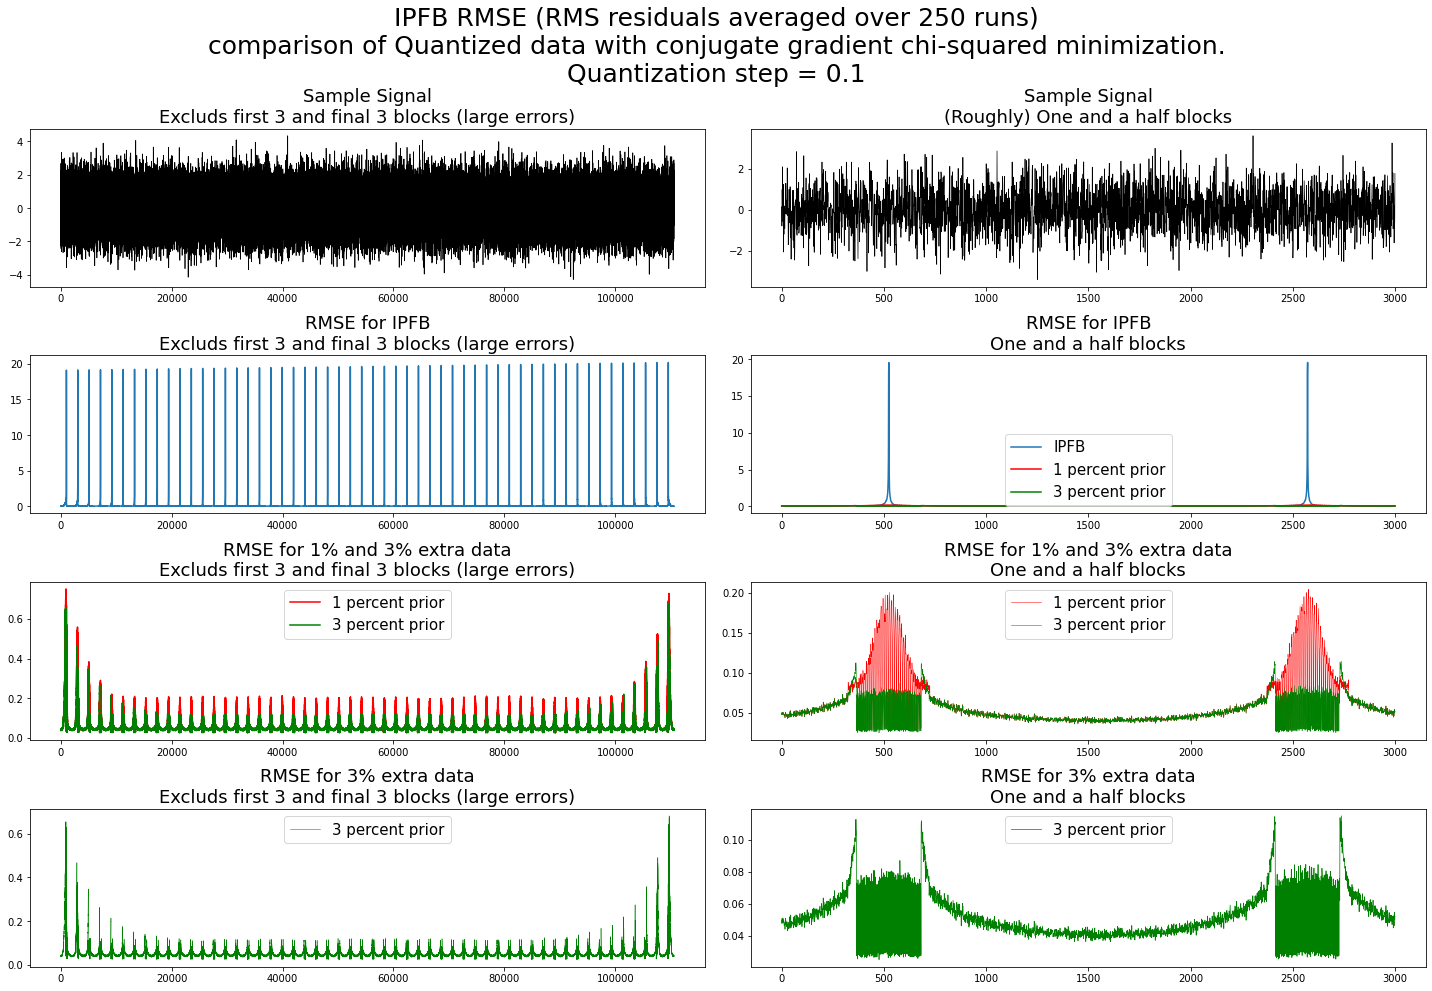

In [176]:
idx1 = np.arange(2*LBLOCK,20*LBLOCK) 
idx1 = np.arange(3*LBLOCK,len(x_arr[0]) - 3*LBLOCK)
idx2 = np.arange(51700,54700) 

plt.subplots(figsize=(20,14))
plt.subplot(421)
plt.title("Sample Signal\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18)
plt.plot(x_arr[0][idx1],linewidth=0.7,color="k")

plt.subplot(422)
plt.title("Sample Signal\n(Roughly) One and a half blocks",fontsize=18)
plt.plot(x_arr[0][idx2],linewidth=0.7,color="k")

plt.subplot(423) 
plt.title("RMSE for IPFB\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_ipfb[idx1]) 

plt.subplot(424) 
plt.title("RMSE for IPFB\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_ipfb[idx2],label="IPFB") 
plt.plot(rmse_1_perc[idx2],color="red",label="1 percent prior") 
plt.plot(rmse_3_perc[idx2],color="green",label="3 percent prior") 
plt.legend(fontsize=15) 

plt.subplot(425) 
plt.title("RMSE for 1% and 3% extra data\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_1_perc[idx1],color="red",label="1 percent prior") 
plt.plot(rmse_3_perc[idx1],color="green",label="3 percent prior")
plt.legend(fontsize=15)

plt.subplot(426) 
plt.title("RMSE for 1% and 3% extra data\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_1_perc[idx2],color="red",linewidth=0.5,label="1 percent prior") 
plt.plot(rmse_3_perc[idx2],color="green",linewidth=0.5,label="3 percent prior")
plt.legend(fontsize=15)

plt.subplot(427) 
plt.title("RMSE for 3% extra data\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_3_perc[idx1],color="green",linewidth=0.5,label="3 percent prior") 
plt.legend(fontsize=15) 

plt.subplot(428) 
plt.title("RMSE for 3% extra data\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_3_perc[idx2],color="green",linewidth=0.7,label="3 percent prior") 
plt.legend(fontsize=15) 


plt.suptitle("IPFB RMSE (RMS residuals averaged over 250 runs)\n\
comparison of Quantized data with conjugate gradient chi-squared minimization.\n\
Quantization step = {}".format(delta),fontsize=25)

plt.tight_layout()

plt.savefig("rmse_ipfb_quantization_delta={:.2f}.png".format(delta))

plt.show()